# IBM Streams Segment integration sample application

This sample demonstrates integrating a Streams Python application with the [Segment](https://segment.com/) customer data processing web service.

<ul>
    <a href="#overview">Overview</a>
</ul>
<ol>
    <li><a href="#setup">Setup</a>
        <ul>
            <li>1.1 <a href="#setupStreams">Connection to Streams Instance</a></li>
            <li>1.2 <a href="#setupPackages">Install or upgrade streamsx Python packages</a></li>
            <li>1.3 <a href="#setupSegment">Install or upgrade Segment Python packages</a></li>
        </ul>
    </li>
    <br/>
    <li><a href="#dataProcessingClassesFunctions">Data processing classes and functions</a>
        <ul>
            <li>2.1 <a href="#dataGeneratorClass">Data generator class</a></li>
            <li>2.2 <a href="#countIdentifyData">Class that counts Identify events in a batch</a></li>
            <li>2.3 <a href="#sinkFunction">The sink function</a></li>
        </ul>
    </li>
    <br/>
    <li><a href="#createApplication">Create the application</a>
        <ul>
            <li>3.1 <a href="#mockupWebhookDataPublisher">Mock-up Webhook data publisher</a></li>
            <li>3.2 <a href="#webhookDataPublisher">Webhook data publisher</a></li>
            <li>3.3 <a href="#streamsSegmentIntegration">Streams Segment Integration</a></li>
        </ul>
    </li>
    <br/>
    <li><a href="#cancel">Cancel all jobs</a></li>
</ol>



<a name="overview"></a>

# Overview

**About the sample**

This sample application receives data from a Segment Webhook destination (mocked up for now), processes the data within
the Streams Python application and finally sends new data into Segment, using Segment's Python API.

**How it works**

With the Streams Python API, we will define a topology step by step, describing the flow of data in our streaming application through a number of processing functions. Running the Python code in the notebook will create this graph/flow and finally submit it to the Streams instance.

<img src="https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/04/how-it-works.jpg" alt="How it works">

<br>
<br>


### Documentation & Information links

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [streamsx.topology Python API](https://streamsxtopology.readthedocs.io/)
- [streamsx.endpoint Python API](https://streamsxendpoint.readthedocs.io/)
- [Segment Spec](https://segment.com/docs/spec/)
- [Segment Python Source API](https://segment.com/docs/sources/server/python/)
- [Segment Webhooks Destination](https://segment.com/docs/destinations/webhooks/)





<a id="setup"></a>

# 1. Setup

  
  
<div class="alert alert-block alert-info">
<b>What do we need to set up for our sample application?</b>  
    
+ A connection to a running <b>IBM Streams instance</b> <br> 
   This notebook describes using a Streams instance in IBM Cloud Pak for Data. 
+ <b>streamsx.topology</b> - the Python package providing the IBM Streams standard/basic function set.
+ <b>streamsx.endpoint</b> - the Python package providing the IBM Streams endpoint functionality.
+ <b>Segment account</b> - easily [sign up](https://app.segment.com/signup/) at Segment. The free 'Developer' plan will suffice for this sample.
</div>



<a id="setupStreams"></a>

## 1.1 Add credentials and connection information for the IBM Streams instance

This notebook is running in IBM Cloud Pak for Data and we are using an IBM Streams instance running in IBM Cloud Pak for Data.<br>
To get all required information to connect to the Streams instance, change the instance name in the cell below to the name of the<br>
instance that you plan to use:

- From the navigation menu, click My instances.
- Click the Provisioned Instances tab.
- Update the value of streams_instance_name in the cell below according to your Streams instance name.



In [ ]:

from icpd_core import icpd_util
streams_instance_name = 'sample-streams'     ## Insert the name of your Streams instance here
cfg=icpd_util.get_service_instance_details(name=streams_instance_name)


<a id="setupPackages"></a>

## 1.2 Install or upgrade streamsx Python packages

As described in [Overview](#overview), we need the Python packages providing the Streams functionality to create streaming applications using Python, __streamsx__ and __streamsx.endpoint__.<br>
Run the cell below to upgrade and check which version of the packages is installed.   

In [ ]:
import sys

sys.path.insert(0, '/home/wsuser/.local/lib/python3.6/site-packages')

#!{sys.executable} -m pip install --user --upgrade streamsx
!{sys.executable} -m pip install --user --upgrade streamsx.endpoint

# When you need to install a specific version of the package, run this line instead:
#!{sys.executable} -m pip install --user streamsx==somever
#!{sys.executable} -m pip install --user streamsx.endpoint==somever

# show the installed versions of both packages
import streamsx.topology.context
import streamsx.endpoint as ep
print("INFO: streamsx.topology.context package version: " + streamsx.topology.context.__version__)
print("INFO: streamsx.endpoint package version: " + ep.__version__)

#For more details uncomment lines below.
#!pip show streamsx
#print(cfg)


In [ ]:
inetserver_toolkit = ep.download_toolkit()



<a id="setupSegment"></a>

## 1.3 Install or upgrade Segment Python packages

We use Segment's Python Source API to send data into Segment.
 

In [ ]:
#import sys
!{sys.executable} -m pip install --user --upgrade analytics-python

# show the installed versions of both packages
import analytics
print("INFO: analytics package version: " + analytics.__version__)

<a id="dataProcessingClassesFunctions"></a>

# 2. Data processing classes and functions

First we create some basic data objects containing some of the [common fields](https://segment.com/docs/spec/common/) defined by the Segment API.<br>
These data objects are then used in a class randomly generating data sets and which is connected with a Streams source. It simulates data
that is received via a Segment Webhook destination.


<a id="dataGeneratorClass"></a>

## 2.1 Data generator class

The following class randomly generates data sets mimicking what we would receive, if we connect to a Segment Webhook destination.

In [ ]:
import datetime
import json
import random
import sys
import time


class WebhookDataSource(object):
    
    def __init__(self):
        print("INFO: Webhook Data Source starting up")
        self.msgId           = random.randrange(83657)
        self.anonymousIds    = ["anon124298", "anon215107", "anon306016", "anon497925", "anon588834"]
        self.userIds         = ["f4ca124298", "g3da215107", "h2ea306016", "i1fa497925", "j0ga588834"]
        self.userIdCount     = len(self.userIds)
        self.userTraits      = {"f4ca124298" : {"name": "Liam McAnnac", "email" : "liam@rebcom.org",   "created_at": "today", "age" : 26 }, # str(datetime.datetime.now()
                                "g3da215107" : {"name": "Doug Shmyson", "email" : "doug@darkstar.com", "created_at": "today", "age" : 51 },
                                "h2ea306016" : {"name": "Sid Kattmal",  "email" : "sid@darkstar.com",  "created_at": "today", "age" : 63 },
                                "i1fa497925" : {"name": "Pria Leed",    "email" : "pria@rebcom.org",   "created_at": "today" },
                                "j0ga588834" : {"name": "Hans Olod",    "email" : "hans@consmug.com",  "created_at": "today", "age" : 31 }
                               }
        self.groupIds        = {"f4ca124298" : "7f8eg221bd",
                                "g3da215107" : "6g7fh110ce",
                                "h2ea306016" : "5h6gi009cf",
                                "i1fa497925" : "4i5hj988dg",
                                "j0ga588834" : "3j4ik877eh"
                               }
        self.groupTraits     = {"7f8eg221bd" : {"employees" :  753, "industry" : "Agriculture", "name" : "Crops Inc."},
                                "6g7fh110ce" : {"employees" : 1134, "industry" : "Banking",     "name" : "Money Transfers 4U"},
                                "5h6gi009cf" : {"employees" :  877, "industry" : "Technology",  "name" : "Computers, Parts, and Gadgets"},
                                "4i5hj988dg" : {"employees" : 9654, "industry" : "Retail",      "name" : "Stuv"},
                                "3j4ik877eh" : {"employees" :  162, "industry" : "Services",    "name" : "Call Center Services"}
                               }
        self.previousIds     = {"f4ca124298" : "40340-128128-340340-12812",
                                "g3da215107" : "51451-017017-451451-01701",
                                "h2ea306016" : "62562-906906-562562-90690",
                                "i1fa497925" : "73673-895895-673673-89589",
                                "j0ga588834" : "84784-784784-784784-78478"
                               }
        # The more a call is listed the greater is its probability to occur
        self.apiCallTypes    = ["identify", "track", "page", "group", "track", "page", "alias", "identify", "track", "page"]
        self.apiCallTypeCount= len(self.apiCallTypes)
        self.deviceTemplate  = {"name" : "Apple iPhone 6", "type" : "phone"}
        self.libraryTemplate = {"name" : "unknown", "version" : "unknown"}
        self.requestTemplate = {"channel" : "server",
                                "context" : {},
                                "integrations" : {}, 
                                "messageId" : "",
                                "originalTimestamp" : "",
                                "projectId" : "3bFLcRDK4t",
                                "receivedAt" : "",
                                "sentAt" : "",    # null
                                "timestamp" : "",
                                "type" : "",
                                "userId" : "",
                                "version" : 2,
                                "writeKey" : "mjtapfQAUJ1hiBnfBb7MmBXg0d4UIdLz"
                               }
        self.eventNames      = ["Item Purchased", "Song Played"]
        self.eventNamesCount = len(self.eventNames)
        self.purchasables    = [ {"name" : "NFL Super Grip Football", "revenue" : 14.00}
                                ,{"name" : "Bucket of Baseballs", "revenue" : 129.99}
                                ,{"name" : "NBA Street Basketball", "revenue" : 17.44}
                                ,{"name" : "World Cup Top Glider", "revenue" : 22.50}
                               ]
        self.purchasablesCount = len(self.purchasables)
        self.songs           = [ {"artist" : "Dropkick Murphys", "name" : "Shipping up to Boston"}
                                ,{"artist" : "Boy Harsher", "name" : "Fate"}
                                ,{"artist" : "Suede", "name" : "Life is Golden"}
                                ,{"artist" : "LoneLady", "name" : "Hinterland"}
                                ,{"artist" : "Taj Weekes", "name" : "Vibe Up"}
                                ,{"artist" : "Andrew Bird", "name" : "Sisyphus"}
                                ,{"artist" : "Mine", "name" : "90 Grad"}
                                ,{"artist" : "The Pogues", "name" : "Bottle of Smoke"}
                                ,{"artist" : "BRONCHO", "name" : "All Choked Up"}
                                ,{"artist" : "Betta Lemme", "name" : "Kick the Door"}
                               ]
        self.songsCount      = len(self.songs)
        

    def __enter__(self):
        print("INFO: Webhook Data Source starting up")

    def __exit__(self, excptn_type, excptn_value, traceback):
        if excptn_type or excptn_value or traceback:
            print("WARN: Some exception")
        else:
            print("Process is shutting down")

        
    def generateMessageId(self):
        self.msgId += 1
        return "api-1PSJfRahchop5sGtdqgF8" + "{:06d}".format(self.msgId)

    
    def createContext(self, callType, eventName):
        context = {}
        context["library"] = dict(self.libraryTemplate)

        if callType == "identify":
            context["device"]  = dict(self.deviceTemplate)
            
        if callType == "track":
            if eventName == "Item Purchased":
                context["ip"]  = str(random.randrange(20,60)) + "." + str(random.randrange(0,10)) + "." + str(random.randrange(60,70)) + "." + str(random.randrange(40,50))
            if eventName == "Song Played":
                context["device"]  = dict(self.deviceTemplate)
            
        #if callType == "page":
        #if callType == "group":
        #if callType == "alias":
        
        return context

    
    def createRequest(self, userId, callType, dateTimeString):
        request = dict(self.requestTemplate)
        
        # The following line doesn't work, as 'datetime' cannot be found
        #now = str(datetime.datetime.now())
        
        request["userId"]            = userId
        request["type"]              = callType
        request["messageId"]         = self.generateMessageId()
        request["originalTimestamp"] = dateTimeString
        request["receivedAt"]        = dateTimeString
        request["timestamp"]         = dateTimeString
        
        if callType == "identify":
            request["traits"] = dict(self.userTraits[userId])
        
        eventName = ""
        if callType == "track":
            eventName = self.eventNames[random.randrange(self.eventNamesCount)]
            if eventName == "Item Purchased":
                request["properties"] = self.purchasables[random.randrange(self.purchasablesCount)]
            if eventName == "Song Played":
                request["properties"] = self.songs[random.randrange(self.songsCount)]

        if callType == "page":
            request["name"] = "Tracking HTTP API"
            
        if callType == "group":
            request["groupId"] = self.groupIds[userId]
            request["traits"]  = dict(self.groupTraits[self.groupIds[userId]])

        if callType == "alias":
            request["previousId"] = self.previousIds[userId]

        request["context"] = self.createContext(callType, eventName)

        return request

    
    def __call__(self):
        while True:
            time.sleep(random.uniform(0.0, 0.3))
            userId      = self.userIds[random.randrange(self.userIdCount)]
            apiCallType = self.apiCallTypes[random.randrange(self.apiCallTypeCount)]
            request     = self.createRequest(userId, apiCallType, str(datetime.datetime.now()))
            #yield json.dumps(request, indent=3)
            yield request


<a id="countIdentifyData"></a>

## 2.2 Class that counts Identify events in a batch

The class defines a batch function that counts the number of Identify messages per user and collects the data in a dictionary.

In [ ]:
class IdentifyCounter:
    def __call__(self, tuples_in_batch):
        # Create a null initialized dict of all userIds in this batch
        userIdsInBatch = [tpl["userId"] for tpl in tuples_in_batch] 
        userIdsInBatch.sort()
        #print(userIdsInBatch, file=sys.stdout)
        userIdentifyCounter = dict.fromkeys(userIdsInBatch, 0)
        
        # Count the Identify events per userId
        for tpl in tuples_in_batch:
            if tpl["type"] == "identify":
                userIdentifyCounter[tpl["userId"]] += 1
        
        print(userIdentifyCounter, file=sys.stdout)
        sys.stdout.flush()
    
        return userIdentifyCounter


<a id="sinkFunction"></a>

## 2.3 The sink function

The following cell defines a function which works as a sink in the Streams application. It takes the output of the IdentifyCounter  
class and uses Segment's Python API to produce a new Track event for every entry in the dictionary.  
The Segment Python API needs your Write Key to be allowed to send data. You can determine your key when you log in to your  
Segment workspace and open the page for your Python source.

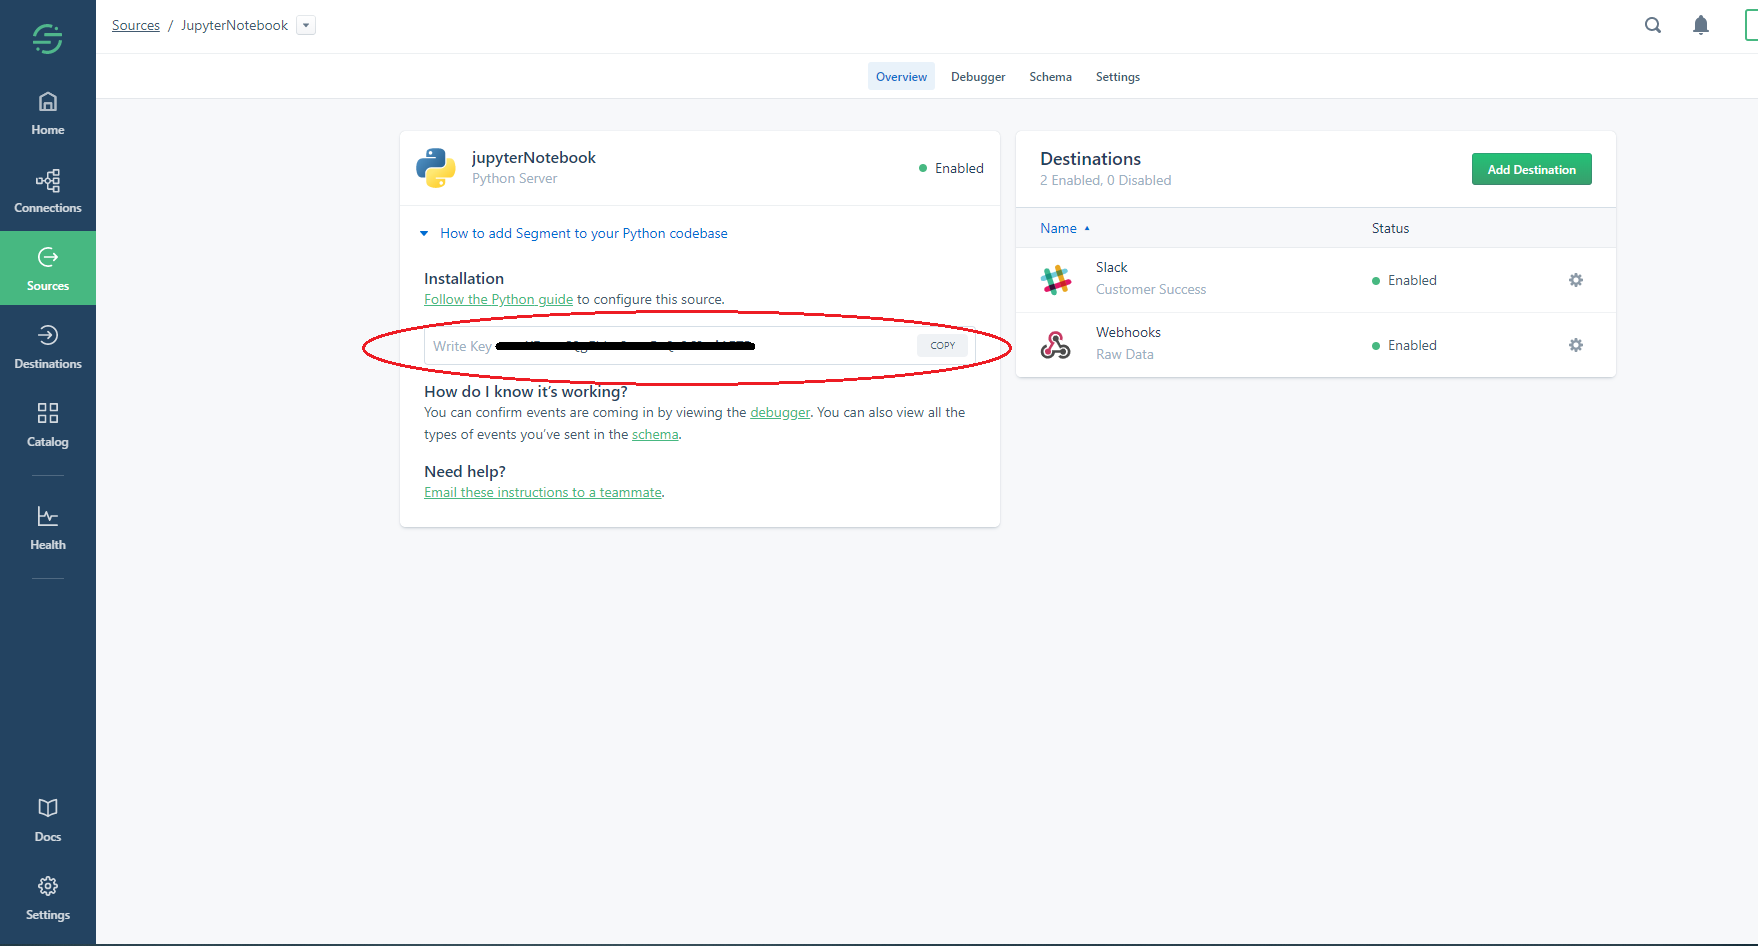


In [ ]:
import analytics
import sys

def sendIdentifyAggregateEvents(tuple):
    #analytics.write_key = segmentWriteKey
    analytics.write_key = '1m1YI75eGQgFkktC4t1RwQvlCloiAFTD'
    for userId in tuple.keys():
        props = { 'timesIdentified' : tuple[userId]}
        analytics.track(userId, '"User Identified in Batch"', props)
        

# A pass-through filter needed to attach a view at subscribe's output
def alwaysTrueFilter(tuple):
    return True


<a id="createApplication"></a>

# 3. Create the application

We will split our application into three parts. Two applications that publish mock-up repectively real Webhook data,  
The third application consumes the data, transforms it, and creates new "Track" events for the Segment service.

For more information refer to: [IBM Streams Python support](https://streamsxtopology.readthedocs.io/en/stable/index.html).

<a id="mockupWebhookDataPublisher"></a>

## 3.1 Mock-up Webhook data publisher

This small application creates a topology introducing the generator class as a source. It then publishes the source's data for other applications to consume.


In [ ]:
from streamsx.topology.schema import CommonSchema
from streamsx.topology.topology import Topology

# Create topology
mockupDataTopo = Topology(name="MockupWebhookData")

# Use WebhookDataSource as a Streams source
mockupDataStream = mockupDataTopo.source(WebhookDataSource())

# Attach a view to watch the data stream when running
mockupDataStream_view = mockupDataStream.view(name="Mockup data", description="Mockup data stream")

# Publish mockup data
mockupDataStream.publish(topic="SegmentWebhookData", schema=CommonSchema.Json, name="MockupWebhookData")


### Submit the "Mock-up Webhook data publisher" job

In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False

# submit the topology
submissionResultMockupData = context.submit ("DISTRIBUTED", mockupDataTopo, config=cfg)
#print(submissionResultMockupData)

# The submission_result object contains information about the running application, or job
mockupDataJob = None
if submissionResultMockupData.job:
    mockupDataJob = submissionResultMockupData.job
    print ("JobId: ", mockupDataJob.id , "\nJob name: ", mockupDataJob.name)


### Inspect the data using a view

In [ ]:
from streamsx.topology import context

# Show 5 seconds of raw webhook data
if mockupDataJob:
    queue = mockupDataStream_view.start_data_fetch()
    timeSpan = time.time() + 5;
    while time.time() < timeSpan:
        print(queue.get())
    mockupDataStream_view.stop_data_fetch()

### Cancel the job

The following cell generates a widget you can use to cancel the job. If you cancel a job publishing data, jobs still subscribed to it will not receive data afterwards.

In [ ]:
# Cancel job button
submissionResultMockupData.cancel_job_button()


<a id="webhookDataPublisher"></a>

## 3.2 Webhook data publisher

This small application creates a topology using streamsx.endpoint.inject() as a source. It, too, publishes the source's data for other applications to consume. Using the defaults, 'inject())' is reached via the URL: http://localhost:8080/HTTPJSONInjection/ports/output/0/inject .


In [ ]:
from streamsx.topology.topology import *
from streamsx.topology.schema import *
import streamsx.topology.context
import streamsx.endpoint as endpoint


# Create topology
webhookDataTopo = Topology(name="WebhookData")

# Add Segment's Python API to Streams application context
webhookDataTopo.add_pip_package('analytics-python')


# Use WebhookDataSource as a Streams source
# Injection URL (application/json): /x/y/ports/output/0/inject
#webhookDataStream = ep.inject(webhookDataTopo, context='streams-segment-sample', name='jsoninject', monitor='endpoint-monitor')
webhookDataStream = ep.inject(webhookDataTopo, context='streams-segment-sample', name='jsoninject', monitor=None)

# Attach a view to watch the data stream when running
webhookDataStream_view = webhookDataStream.view(name="Webhook data", description="Webhook data stream")


# Publish mockup data
webhookDataStream.publish(topic="SegmentWebhookDataInJson", schema=CommonSchema.Json, name="WebhookData")


### Submit the "Webhook data publisher" job

In [ ]:
from streamsx.topology import context
from streamsx.spl.toolkit import add_toolkit

add_toolkit(webhookDataTopo, inetserver_toolkit)

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False

# Give the job a unique name 
job_config = context.JobConfig(tracing='info', job_name='segment-webhook-peer')
job_config.add(cfg)

# submit the topology
submissionResultWebhookData = None
submissionResultWebhookData = context.submit ("DISTRIBUTED", webhookDataTopo, config=cfg)    # Currently - as the INetserver toolkit isn't installed, this runs into:    CDISP0053E ERROR: An unknown identifier was referenced in the SPL program: com.ibm.streamsx.inet.rest::HTTPJSONInjection.
print(submissionResultWebhookData)

# The submission_result object contains information about the running application, or job
webhookDataJob = None
if submissionResultWebhookData != None and submissionResultWebhookData.job:
    webhookDataJob = submissionResultWebhookData.job
    print ("JobId: ", webhookDataJob.id , "\nJob name: ", webhookDataJob.name)


### Inspect the data using a view

In [ ]:
!curl -k --header 'Content-Type: application/json' --request POST --data '{"item1":"a","item2":"a"}'  https://streams-endpointmonitor:8443/segment-webhook-peer/streams-segment-sample/jsoninject/ports/output/0/inject

In [ ]:
from streamsx.topology import context

# Show 5 seconds of raw webhook data
if webhookDataJob:
    queue = webhookDataStream_view.start_data_fetch()
    timeSpan = time.time() + 5;
    while time.time() < timeSpan:
        print(queue.get())
    webhookDataStream_view.stop_data_fetch()

### Cancel the job

The following cell generates a widget you can use to cancel the job. If you cancel a job publishing data, jobs still subscribed to it will not receive data afterwards.

In [ ]:
# Cancel job button
if submissionResultWebhookData != None:
    submissionResultWebhookData.cancel_job_button()


<a id="streamsSegmentIntegration"></a>

## 3.3 Streams Segment Integration

The application creates a topology that subscribes to the topic used by above applications. It then transforms some of the data and sends a new 'Track' event to Segment.

In [ ]:
from streamsx.topology.topology import Topology
import streamsx.topology.context


# Create topology
segmentTopo = Topology(name="StreamsSegmentIntegration")

# Add Segment's Python API to Streams application context
segmentTopo.add_pip_package('analytics-python')

# Use WebhookDataSource as a Streams source
webhookDataStream = segmentTopo.subscribe(topic="SegmentWebhookData", schema=CommonSchema.Json)

# A clutch to attach a view to subscribe()'s output
filteredWebhookDataStream = webhookDataStream.filter(alwaysTrueFilter)

# Attach a view to watch the data stream when running
webhookDataStream_view = filteredWebhookDataStream.view(name="Webhook data", description="Webhook data stream")

# Define a batch window and count Identify events per user
webhookDataBatch = filteredWebhookDataStream.batch(20)
identifyEventCount = webhookDataBatch.aggregate(IdentifyCounter())
identifyEventCount_view = identifyEventCount.view(name="IdentifyEventCounts", description="Data set containing the count of Identify events per user for the last batch");

identifyEventCount.for_each(sendIdentifyAggregateEvents)


### Submit the application

The next cell submits the application for execution and prints the resulting job id.


In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False

# submit the topology
submissionResult = context.submit ("DISTRIBUTED", segmentTopo, config = cfg)
#print(submission_result)

# The submission_result object contains information about the running application, or job
streamsJob = None
if submissionResult.job:
    streamsJob = submissionResult.job
    print ("JobId: ", streamsJob.id , "\nJob name: ", streamsJob.name)


### Use the views to access data from the job

Now that the job is started, use the `View` objects you created before to start viewing data from a `Stream`.

In [ ]:
from streamsx.topology import context

# Show 5 seconds of raw webhook data
if streamsJob:
    queue = webhookDataStream_view.start_data_fetch()
    timeSpan = time.time() + 5;
    while time.time() < timeSpan:
        print(queue.get())
    webhookDataStream_view.stop_data_fetch()

In [ ]:
from streamsx.topology import context

# Show 30 seconds of aggregated identify data
if streamsJob:
    queue = identifyEventCount_view.start_data_fetch()
    timeSpan = time.time() + 30;
    while time.time() < timeSpan:
        print(queue.get())
    identifyEventCount_view.stop_data_fetch()


<b> Display the results in real time</b>  

Calling `View.display()` from the notebook displays the results of the view in a table that is updated in real-time.

In [ ]:
# Display the results for 30 seconds
#identifyEventCount_view.display(duration=30)

<b> See job status </b>  

You can view job status and logs by going to **My Instances** > **Jobs**. Find your job based on the id printed above.
Retrieve job logs using the "Download logs" action from the job's context menu.

To view other information about the job such as detailed metrics, access the Streams Console.  Go to **My Instances** > **Provisioned Instances**. Select the Streams instance and open the URL listed under *externalConsoleEndpoint* or *serviceConsoleEndpoint*.

### Cancel the job

The following cell generates a widget you can use to cancel the job. If you cancel a job publishing data, jobs still subscribed to it will not receive data afterwards.

In [ ]:
# Cancel job button
submissionResult.cancel_job_button()


<a name="cancel"></a>

# 4. Cancel all jobs

The following cell interacts with the jobs through the [Job](https://streamsxtopology.readthedocs.io/en/stable/streamsx.rest_primitives.html#streamsx.rest_primitives.Job) object returned from submission. It uses `job.cancel()` to cancel the running jobs directly.

In [ ]:
# Cancel all jobs without displaying a button
#if streamsJob != None:
#    streamsJob.cancel()
#if webhookDataJob != None:
#    webhookDataJob.cancel()
#if mockupDataJob != None:
#    mockupDataJob.cancel()


# Summary

We have seen how we can receive data sent from a Segment Webhook destination into a Streams application. In the Streams Python application we can easily access the data elements of a dynamic data model and process the data to gain new insights. Finally, we have seen that we can send these insights back into Segment using their Python API. This shows, that Streams running in a notebook can become a Segment Python server source.
